In [1]:
from IPython.display import ipd
from tqdm.notebook import tqdm
import librosa
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import torch
import torch.nn as nn

In [2]:
audio_endings = (".mp3", ".wav", ".flac")

In [3]:
class AudioDataset:
    """
    Organize and load an audio dataset split into different directories
    """
    def __init__(self, ds_dir, sr, duration, shuffle=True, random_state=42):
        """
        """
        self.sr = sr
        self.duration = duration
        self.current_file_idx = 0
        self.files = []
        for r, d, f in os.walk(ds_dir):
            for file in f:
                if file.endswith(audio_endings):
                    self.files.append(os.path.join(r, file))
                    
        if shuffle:
            rand = random.Random(random_state)
            rand.shuffle(self.files)
            
    def num_samples(self):
        """
        Files/Samples in audio set
        """
        return len(self.files)
    
    def load(self, file_idxs, sr=None, duration=None, pbar=None):
        """
        Load the specified file indices as an np array of shape
        """
        if sr is None:
            sr = self.sr
        if duration is None:
            duration = self.duration
        ys = []
        if pbar is not None:
            pbar.reset(total=len(file_idxs))
        for file_idx in file_idxs:
            y, _ = librosa.load(self.files[file_idx], sr = sr,
                               mono=True, offset =0.0, duration=duration)
            y = librosa.util.fix_length(y, int(sr*duration), mode="wrap")
            ys.append(y)
            if pbar is not None:
                pbar.update(1)
        return np.array(ys)
    def load_next(self, batch_size, sr=None, duration=None, pbar=None):
        """
        Load the next batch_size files as an np array of shape (batch_size, sr*duration)
        """
        if self.cuurent_file_idx + batch_size>self.num_samples():
            self.current_file_idx = 0
        file_idxs = range(self.current_file_idx, self.current_file_idx + batch_size)
        
        self.current_file_idx += batch_size
        return self.load(file_idxs, sr= sr, duration=duration, pbar=pbar)
    def reset_next(self):
        """Reset file index for the load_next function"""
        self.current_file_idx = 0

In [9]:
import matplotlib.pyplot as plt
import torch
import torchaudio
import warnings
warnings.filterwarnings("ignore")
import IPython.display as ipd
X = torch.from_numpy(voice)

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
def to_torch(*arrays, device=device, dtype=dtype):
    if len(arrays) == 1:
        array = arrays[0]
        if isinstance(array, np.ndarray):
            array = torch.from_numpy(array)
        return array.to(device, dtype)
    ret = ()
    for array in arrays:
        ret += to_torch(array, device=device, dtype=dtype),
    return ret

def to_np(*arrays):
    if len(arrays) == 1:
        return arrays[0].detach().cpu().numpy()
    ret = ()
    for array in arrays:
        ret += to_np(array),
    return ret

In [31]:
voice_ds = AudioDataset('../input/libri-dataset-train-100/LibriSpeech/train-clean-100/3526/', sr=8000, duration=4.9)
# ads = AudioDataSet('datasets/urban/UrbanSound8K/audio')

In [36]:
y = voice_ds.load([3])
ipd.Audio(y, rate=8000)

In [40]:
class AudioSSNNIO():
    """
    Class to control Neural Network Input/Output for project in Audio Source Separation
    """
    def __init__(self, sr, duration):
        """
        Initialize with sr, duration, and the number of sources.
        """
        self.sr = sr
        self.duration = duration
        
    def audio_to_nn_input(self, X_batch):
        """
        Transform the given mixed signal for the neural network to input.
        X_batch will have shape (batch_size, len(y)) where len(y) = sr*duration.
        """
        raise NotImplementedError
    def audio_to_nn_output(self, Y_batch):
        """
        Transform the given source separated signals for the neural network to output.
        Y_batch will have shape (batch_size, num_sources=2, len(y)) where len(y) = sr*duration.
        """
        raise NotImplementedError
        
    def nn_input_to_audio(self, X_batch):
        """
        Transform the input of the neural network back into usable audio.
        X_batch will have shape (batch_size, nn_num_input_channels(), h, w) where h, w are 
        determined by the size of the input spectrum in audio_to_nn_input(...).
        """
        raise NotImplementedError

    def nn_output_to_audio(self, Y_batch):
        """
        Transform the output of the neural network back into usable audio.
        Y_batch will have shape (batch_size, nn_num_output_channels(), h, w) where h, w are 
        determined by the size of the input spectrum in audio_to_nn_output(...).
        """
        raise NotImplementedError
        
    def show_play_nn_input(self, X_batch, ts=["raw", "audio"], sample_idx=0):
        """
        Convenience wrapper to fast show and play network input.
        """
        y = self.nn_input_to_audio(X_batch)[sample_idx]
        return self.show_play_audio(y, ts)
    def show_play_nn_output(self, Y_batch, ts=["raw", "audio"], sample_idx=0):
        """
        Convenience wrapper to fast show and play network output.
        """
        y = self.nn_output_to_audio(Y_batch)[sample_idx]
        return self.show_play_audio(y, ts)
    
    # for jupyter notebook only
    def show_play_audio(self, y, ts=["raw", "audio"]):
        """
        Show the signal y in a jupyter notebook. 
        ts determines different ways you want to show the signal. 
        ts can have:
        -"raw"
        -"audio"
        other options can be added on by different implementations.
        """
        
        if "raw" in ts:
            plt.plot(np.linspace(0, self.duration, len(y)), y)
            plt.show()
        if "audio" in ts:
            display(Audio(y, rate=self.sr))

In [58]:
class MagNNIO(AudioSSNNIO):
    def __init__(self, sr, duration, n_fft=300, normalized=False):
        super().__init__(sr, duration)
        self.n_fft = n_fft
        self.normalized = normalized
        
    def audio_to_nn_input(self, X_batch):
        # X_batch is (batch_size, len(y))
        
        X_batch = X_batch.stft(n_fft=self.n_fft, normalized=self.normalized) #stft
        
        # magphase
        X_batch_mag, X_batch_phase = torchaudio.functional.magphase(X_batch)
        X_batch = X_batch_mag
        
        return X_batch[:, None, ...], X_batch_phase[:, None, ...]
    
    def audio_to_nn_output(self, Y_batch):
        # Y_batch is (batch_size, num_sources=2, len(y))
        
        # only the voice part
        Y_batch = Y_batch[:, 0, :].stft(n_fft=self.n_fft, normalized=self.normalized) #stft
        
        #magphase
        Y_batch_mag, Y_batch_phase = torchaudio.functional.magphase(Y_batch)
        Y_batch = Y_batch_mag
        # ignoring Y_batch_phase
        
        return Y_batch[:, None, ...]
    
    def nn_input_to_audio(self, X_batch, X_batch_phase):
        X_batch, X_batch_phase = X_batch[:, 0, ...], X_batch_phase[:, 0, ...]
        
        X_batch_real = X_batch * torch.cos(X_batch_phase)
        X_batch_imag = X_batch * torch.sin(X_batch_phase)
        X_batch = torch.stack((X_batch_real, X_batch_imag), dim=-1)
        
        X_batch = torch.istft(X_batch, n_fft=self.n_fft, #istft
                                              normalized=self.normalized, length=int(self.sr*self.duration))
        return X_batch
    
    def nn_output_to_audio(self, Y_batch, X_batch, X_batch_phase, transform_X_batch=True):
        if transform_X_batch:
            X_batch = self.nn_input_to_audio(X_batch, X_batch_phase)
        Y_batch = Y_batch[:, 0, ...]
        X_batch_phase = X_batch_phase[:, 0, ...]
        
        Y_batch_real = Y_batch * torch.cos(X_batch_phase)
        Y_batch_imag = Y_batch * torch.sin(X_batch_phase)
        Y_batch = torch.stack((Y_batch_real, Y_batch_imag), dim=-1)
        
        Y_batch = torch.istft(Y_batch, n_fft=self.n_fft, #istft
                                              normalized=self.normalized, length=int(self.sr*self.duration))
        

        
        Y_batch_noise = X_batch - Y_batch
        
        Y_batch = torch.stack((Y_batch, Y_batch_noise), dim=-2)
        return Y_batch

    def show_play_nn_input(self, X_batch, X_batch_phase, ts=["raw", "audio"], sample_idx=0):
        """
        Convenience wrapper to fast show and play network input.
        """
        y = self.nn_input_to_audio(X_batch, X_batch_phase)[sample_idx]
        return self.show_play_audio(y, ts)
    
    def show_play_nn_output(self, Y_batch, X_batch, X_batch_phase, transform_X_batch=True, ts=["raw", "audio"], sample_idx=0):
        """
        Convenience wrapper to fast show and play network output.
        """
        y = self.nn_output_to_audio(Y_batch, X_batch, X_batch_phase, transform_X_batch)[sample_idx][0]
        return self.show_play_audio(y, ts)
        
        
    # for jupyter notebook only
    def show_play_audio(self, y, ts=["raw", "audio"]):
        spectrogram = y.stft(n_fft=self.n_fft, normalized=self.normalized)
        spec_mag, spec_phase = torchaudio.functional.magphase(spectrogram)
        
        if "mag" in ts:
            plt.figure(figsize=(10,4))
            plt.imshow(spec_mag.numpy())
            plt.colorbar(format="%2.2f")
            plt.title("Magnitude of STFT")
            plt.tight_layout()
            plt.show()
        if "detail" in ts:
            fig, axs = plt.subplots(2,2, figsize=(10,4))
            axs[0, 0].set_title("Magnitude")
            axs[0, 1].set_title("Phase")
            axs[1, 0].set_title("Real Part")
            axs[1, 1].set_title("Imag Part")
            
            axs[0, 0].imshow(spec_mag.numpy())
            axs[0, 1].imshow(spec_phase.numpy())
            axs[1, 0].imshow(spectrogram[..., 0].numpy())
            axs[1, 1].imshow(spectrogram[..., 1].numpy())
            plt.show()
        super().show_play_audio(y, ts)

In [59]:
class AudioSSDS(torch.utils.data.Dataset):
    # sources is a list of sources
    def __init__(self, sr, duration, sources=None):
        if isinstance(sources, tuple):
            sources = list(sources)
        if isinstance(sources, list):
            sources = torch.stack(sources, dim=1)
    
        
        self.num_sources = sources.shape[1]
        self.sr = sr
        self.duration = duration
        
        self.X = sources.sum(dim=1)
        self.Y = sources
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [66]:
!pip install torchsummary -q
from torchsummary import summary

In [61]:
def get_block_layer(c_in, c_out, kernel_size=3, padding=1):
    return nn.Sequential(nn.BatchNorm2d(c_in), 
                         nn.ReLU(), 
                         nn.Conv2d(c_in, c_out, kernel_size, padding=padding))
    

class NeuralTransform(nn.Module):
    def __init__(self, c_in, c_out, num_layers, gr):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        
        self.layers = nn.ModuleList()
        
        c_prev = c_in
        for layer_idx in range(num_layers-1):
            self.layers.append(get_block_layer(c_prev, gr))
            c_prev += gr
            
        self.final_layer = get_block_layer(c_prev, c_out)
        
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.cat((x, layer(x)), axis=1)
        x = self.final_layer(x)
        return x
    
def get_down_sample_layer(c, kernel_size=(2,2), stride=(2,2)):
    return nn.Conv2d(c, c, kernel_size=kernel_size, stride=stride)
def get_up_sample_layer(c, kernel_size=(2,2), stride=(2,2)):
    return nn.ConvTranspose2d(c, c, kernel_size=kernel_size, stride=stride)

# frequency time convolutional neural network for generator
class FTCNNGenerator(nn.Module):
    def __init__(self, c_in, cs, c_out=None, num_layers_per_block=4, block_gr=24):
        super().__init__()
        
        if c_out is None:
            c_out = c_in
        
        rcs = list(reversed(cs))
        
        self.conv_first = nn.Conv2d(c_in, cs[0], kernel_size=1)
        self.conv_last = nn.Conv2d(rcs[-1], c_out, kernel_size=1)
        
        self.left = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.right = nn.ModuleList([NeuralTransform(2*c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(rcs, rcs[1:])])
        
        self.midnt = NeuralTransform(cs[-1], cs[-1], num_layers_per_block, block_gr)
        
        self.downs = nn.ModuleList([get_down_sample_layer(c) for c in cs[1:]])
        self.ups = nn.ModuleList([get_up_sample_layer(c) for c in rcs[:-1]])
    
    def forward(self, x):
        x = self.conv_first(x)
        
        residuals = []
        shapes = []
        for nt, down in zip(self.left, self.downs):
            x = nt(x)
            residuals.insert(0, x)
            shapes.insert(0, x.shape)
            x = down(x)
        
        x = self.midnt(x)
        
        for nt, up, residual, shape in zip(self.right, self.ups, residuals, shapes):
            x = up(x, output_size=shape)
            x = torch.cat((x, residual), dim=1)
            x = nt(x)
        
        x = self.conv_last(x)
        return x
    
    
    
# frequency time convolutional neural network for discriminator
class FTCNNDiscrimminator(nn.Module):
    def __init__(self, c_in, cs, input_hw, fcs=[100, 10, 10, 1], num_layers_per_block=4, block_gr=24):
        super().__init__()
        
        self.conv_first = nn.Conv2d(c_in, cs[0], kernel_size=1)
        
        self.nts = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.dss = nn.ModuleList([get_down_sample_layer(c_out) for c_out in cs[1:]])
        
        h = input_hw[0] // (2**len(self.dss))
        w = input_hw[1] // (2**len(self.dss))
    
        self.fc1d1 = cs[-1]*h*w
            
        fcs.insert(0, self.fc1d1)
        self.fcs = nn.ModuleList([nn.Linear(d1, d2) for d1, d2 in zip(fcs, fcs[1:])])
    
    def forward(self, x):
        x = self.conv_first(x)
        
        for nt, down in zip(self.nts, self.dss):
            x = nt(x)
            x = down(x)
        x = x.view(-1, self.fc1d1)
        
        for fc in self.fcs[:-1]:
            x = fc(x)
            x = torch.relu(x)
        
        x = self.fcs[-1](x)
        x = torch.sigmoid(x)
        return x[:, 0]

In [63]:
sr = 8000
duration = 2.0
voice_ds = AudioDataset("../input/libri-dataset-train-100/LibriSpeech/train-clean-100/103/",
                       sr=sr, duration=duration)
num_samples = voice_ds.num_samples()
source1 = voice_ds.load(range(num_samples), pbar=tqdm())
noise_ds = AudioDataset("../input/urbansound8k/fold5/",
                       sr=sr, duration=duration)
source2 = noise_ds.load(range(num_samples), pbar=tqdm())

source1 = torch.from_numpy(source1)
source2 = torch.from_numpy(source2)
audiossds_test = AudioSSDS(sr, duration, sources=(source1[:10], source2[:10]))
audiossds_train = AudioSSDS(sr, duration, sources=(source1[10:], source2[10:]))
audionnio = MagNNIO(sr, duration, normalized=True)


x, y = audiossds_test[:1]
input_shape, output_shape = audionnio.audio_to_nn_input(x)[0].shape, audionnio.audio_to_nn_output(y).shape
print("nn input shape: ", input_shape)
print("nn output shape: ", output_shape)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

nn input shape:  torch.Size([1, 1, 151, 214])
nn output shape:  torch.Size([1, 1, 151, 214])


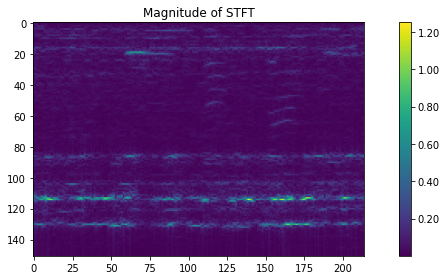

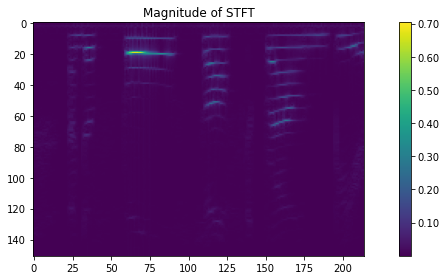

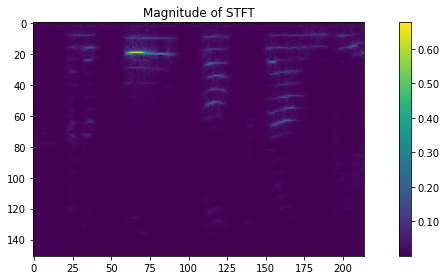

In [64]:
sample_idx = 4

X_test, Y_test = audiossds_test[:]

audionnio.show_play_audio(X_test[sample_idx], ["mag", "audio"])

audionnio.show_play_audio(Y_test[sample_idx, 0], ["mag", "audio"])

X_test, X_test_phase = audionnio.audio_to_nn_input(X_test)
Y_test = audionnio.audio_to_nn_output(Y_test)

audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, True, ["mag","audio"], sample_idx)

In [67]:
model_g = FTCNNGenerator(input_shape[0], [6, 6, 6 ,6], 
                         num_layers_per_block=4, block_gr=24).to(device, dtype)
summary(model_g, input_size=input_shape[1:])

model_d = FTCNNDiscrimminator(input_shape[0], [6, 6, 6, 6], input_hw = input_shape[2:], 
                              num_layers_per_block=4, block_gr=24).to(device, dtype)
summary(model_d, input_size=input_shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 151, 214]              12
       BatchNorm2d-2          [-1, 6, 151, 214]              12
              ReLU-3          [-1, 6, 151, 214]               0
            Conv2d-4         [-1, 24, 151, 214]           1,320
       BatchNorm2d-5         [-1, 30, 151, 214]              60
              ReLU-6         [-1, 30, 151, 214]               0
            Conv2d-7         [-1, 24, 151, 214]           6,504
       BatchNorm2d-8         [-1, 54, 151, 214]             108
              ReLU-9         [-1, 54, 151, 214]               0
           Conv2d-10         [-1, 24, 151, 214]          11,688
      BatchNorm2d-11         [-1, 78, 151, 214]             156
             ReLU-12         [-1, 78, 151, 214]               0
           Conv2d-13          [-1, 6, 151, 214]           4,218
  NeuralTransform-14          [-1, 6, 1

In [70]:
!pip install pytorch_ssim -q
import pytorch_ssim
mse = nn.MSELoss()
bce = nn.BCELoss()
lambda_mse = 1e2
lambda_noise_weighted_mse = 1e4
lambda_ssim = 0.0

def generator_loss_function_base(Y_batch_pred, Y_batch, X_batch):
    # normal MSE loss for now
    Y_batch_noise = X_batch-Y_batch
    Y_batch_noise_pred = X_batch-Y_batch_pred
    
    # normal mse loss
    loss_mse = lambda_mse * mse(Y_batch_pred, Y_batch)
    
    # noise weighted mse loss
    loss_noise_weighted_mse = lambda_noise_weighted_mse * torch.mean(((Y_batch_pred-Y_batch)**2) * torch.abs(Y_batch_noise))
    
    # SSIM loss
#     loss_ssim = lambda_ssim * (2 - pytorch_ssim.ssim(Y_batch, Y_batch_pred) - pytorch_ssim.ssim(Y_batch_noise, Y_batch_noise_pred))
    loss_ssim = 0.0
    
    # total loss
    loss = loss_mse + loss_noise_weighted_mse + loss_ssim
    print(f'{loss_mse}+{loss_noise_weighted_mse}+{loss_ssim}={loss}')
    
    return loss

In [71]:
X_test, Y_test = audiossds_test[:50]
X_test, Y_test = audionnio.audio_to_nn_input(X_test), audionnio.audio_to_nn_output(Y_test)
X_test, X_test_phase = X_test
print(X_test.shape)
print(Y_test.shape)

torch.Size([10, 1, 151, 214])
torch.Size([10, 1, 151, 214])


In [72]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print("Test Loss: ", generator_loss_function_base(Y_test_pred, Y_test, X_test).item())

5.404711723327637+307.5038146972656+0.0=312.9085388183594
Test Loss:  312.9085388183594


Showing example:  0
Input:


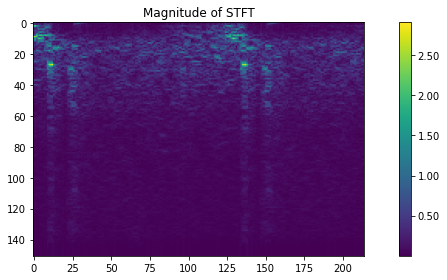

Target:


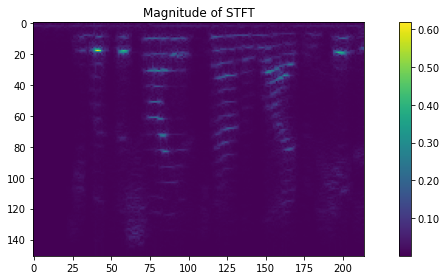

Output:


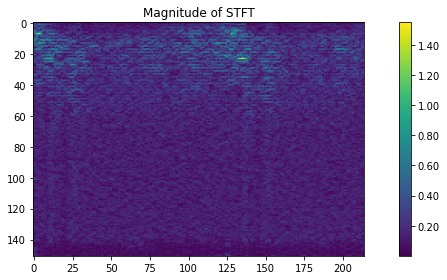

In [73]:
test_example_idx = 0
print("Showing example: ", test_example_idx)
print("Input:")
audionnio.show_play_nn_input(X_test, X_test_phase, ts=["mag", "audio"], sample_idx=test_example_idx)
print("Target:")
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=["mag", "audio"], sample_idx=test_example_idx)
print("Output:")
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=["mag", "audio"], sample_idx=test_example_idx)

In [81]:
import gc
def get_batch_indices(all_indices, batch_size, shuffle=True, drop_last=False):

    if drop_last:
        num_batches = len(all_indices)//batch_size
    else:
        num_batches = math.ceil(len(all_indices)/batch_size)
    batch_indices = [all_indices[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    if shuffle:
        np.random.shuffle(batch_indices)
    return batch_indices

def clear_mem(print_mem=False):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        if print_mem:
            print("total: ", torch.cuda.get_device_properties(0).total_memory/1e9)
            print("cached: ", torch.cuda.memory_cached()/1e9)
            print("allocated: ", torch.cuda.memory_allocated()/1e9)
        

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

5.518915176391602+41.896881103515625+0.0=47.415794372558594


Epoch 1 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

20.82173728942871+192.1489715576172+0.0=212.970703125


Epoch 2 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

5.3029398918151855+17.451921463012695+0.0=22.75486183166504


Epoch 3 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2.4874322414398193+13.25797176361084+0.0=15.745404243469238


Epoch 4 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

4.35246467590332+20.67262840270996+0.0=25.02509307861328


Epoch 5 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6.339748859405518+15.806438446044922+0.0=22.14618682861328


Epoch 6 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

7.231987953186035+6.868371486663818+0.0=14.100358963012695


Epoch 7 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

7.274207592010498+3.3903768062591553+0.0=10.664584159851074


Epoch 8 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6.75735330581665+4.883113861083984+0.0=11.640466690063477


Epoch 9 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

5.5017805099487305+5.021897315979004+0.0=10.523677825927734


Epoch 10 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

3.791754961013794+2.962841749191284+0.0=6.754596710205078


Epoch 11 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2.364553213119507+1.9342787265777588+0.0=4.298831939697266


Epoch 12 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.3070640563964844+1.2736068964004517+0.0=2.5806708335876465


Epoch 13 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.7345162034034729+1.1932309865951538+0.0=1.9277472496032715


Epoch 14 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5637203454971313+1.2984583377838135+0.0=1.8621786832809448


Epoch 15 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.6640684604644775+1.3152694702148438+0.0=1.9793379306793213


Epoch 16 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.9285852313041687+1.2781333923339844+0.0=2.206718683242798


Epoch 17 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.236283540725708+1.2120174169540405+0.0=2.448300838470459


Epoch 18 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.4749220609664917+1.123592495918274+0.0=2.5985145568847656


Epoch 19 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.5694552659988403+1.0211915969848633+0.0=2.590646743774414


Epoch 20 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.4973803758621216+0.9143527150154114+0.0=2.4117331504821777


Epoch 21 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.2847626209259033+0.8129216432571411+0.0=2.097684383392334


Epoch 22 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.9930076003074646+0.7240386009216309+0.0=1.7170462608337402


Epoch 23 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.6954280138015747+0.6527951955795288+0.0=1.3482232093811035


Epoch 24 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.45531120896339417+0.6006990075111389+0.0=1.0560102462768555


Epoch 25 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.311299592256546+0.5672085285186768+0.0=0.8785080909729004


Epoch 26 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.27157214283943176+0.5510392189025879+0.0=0.8226113319396973


Epoch 27 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.3171149790287018+0.5496969819068909+0.0=0.866811990737915


Epoch 28 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.41095173358917236+0.5585826635360718+0.0=0.9695343971252441


Epoch 29 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5102712512016296+0.5708262920379639+0.0=1.0810976028442383


Epoch 30 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5783371329307556+0.5782930850982666+0.0=1.156630277633667


Epoch 31 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5931946635246277+0.5742891430854797+0.0=1.1674838066101074


Epoch 32 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5512149333953857+0.5557326674461365+0.0=1.106947660446167


Epoch 33 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.4656212031841278+0.5243232846260071+0.0=0.9899444580078125


Epoch 34 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.3605913817882538+0.4857867360115051+0.0=0.8463780879974365


Epoch 35 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.26308339834213257+0.4476644694805145+0.0=0.7107478380203247


Epoch 36 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.19484947621822357+0.4166662395000458+0.0=0.6115157008171082


Epoch 37 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.16681839525699615+0.3966207504272461+0.0=0.563439130783081


Epoch 38 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.17718634009361267+0.38762006163597107+0.0=0.5648064017295837


Epoch 39 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.21345548331737518+0.386581152677536+0.0=0.60003662109375


Epoch 40 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.25745582580566406+0.3888065814971924+0.0=0.6462624073028564


Epoch 41 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.2916058301925659+0.3898838758468628+0.0=0.6814897060394287


Epoch 42 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.30421239137649536+0.387199729681015+0.0=0.691412091255188


Epoch 43 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.2921768128871918+0.38039708137512207+0.0=0.6725739240646362


Epoch 44 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.26059719920158386+0.37090522050857544+0.0=0.6315023899078369


Epoch 45 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.21982167661190033+0.3609504997730255+0.0=0.5807721614837646


Epoch 46 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.18131369352340698+0.35245880484580994+0.0=0.5337724685668945


Epoch 47 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.15390723943710327+0.34635964035987854+0.0=0.5002669095993042


Epoch 48 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.14154081046581268+0.342511385679245+0.0=0.4840521812438965


Epoch 49 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.14296650886535645+0.3400464951992035+0.0=0.48301300406455994


Epoch 50 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.153138667345047+0.3379334807395935+0.0=0.4910721480846405


Epoch 51 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.16551731526851654+0.33539828658103943+0.0=0.5009155869483948


Epoch 52 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1743793785572052+0.33213192224502563+0.0=0.5065113306045532


Epoch 53 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.17642199993133545+0.32812759280204773+0.0=0.5045496225357056


Epoch 54 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1713055819272995+0.3235476613044739+0.0=0.49485325813293457


Epoch 55 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.16113139688968658+0.31852617859840393+0.0=0.4796575903892517


Epoch 56 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1492742896080017+0.313215047121048+0.0=0.4624893367290497


Epoch 57 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1390427052974701+0.3078609108924866+0.0=0.44690361618995667


Epoch 58 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1326124519109726+0.3029245138168335+0.0=0.4355369806289673


Epoch 59 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.13051658868789673+0.2989388704299927+0.0=0.4294554591178894


Epoch 60 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.13176535069942474+0.2963286340236664+0.0=0.42809396982192993


Epoch 61 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1344480663537979+0.2951451241970062+0.0=0.42959320545196533


Epoch 62 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.136530339717865+0.2949548661708832+0.0=0.43148520588874817


Epoch 63 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.13657639920711517+0.29499536752700806+0.0=0.4315717816352844


Epoch 64 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1341460794210434+0.2944670021533966+0.0=0.4286130666732788


Epoch 65 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1297900378704071+0.29285353422164917+0.0=0.4226435720920563


Epoch 66 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.12470680475234985+0.2901102900505066+0.0=0.41481709480285645


Epoch 67 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.12022846937179565+0.28664326667785645+0.0=0.4068717360496521


Epoch 68 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11734693497419357+0.2831093966960907+0.0=0.40045633912086487


Epoch 69 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11641483008861542+0.2801060676574707+0.0=0.3965209126472473


Epoch 70 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11710245162248611+0.27793389558792114+0.0=0.39503633975982666


Epoch 71 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11860862374305725+0.276496559381485+0.0=0.39510518312454224


Epoch 72 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11998491734266281+0.2754107713699341+0.0=0.3953956961631775


Epoch 73 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.12047512084245682+0.2742401957511902+0.0=0.3947153091430664


Epoch 74 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11974043399095535+0.27273091673851013+0.0=0.3924713432788849


Epoch 75 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11790996789932251+0.27090299129486084+0.0=0.38881295919418335


Epoch 76 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11545979976654053+0.2690013349056244+0.0=0.3844611346721649


Epoch 77 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11299271136522293+0.2673249840736389+0.0=0.38031768798828125


Epoch 78 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.11101353168487549+0.26604780554771423+0.0=0.3770613372325897


Epoch 79 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10977354645729065+0.265138179063797+0.0=0.37491172552108765


Epoch 80 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10923376679420471+0.2643953263759613+0.0=0.373629093170166


Epoch 81 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10913736373186111+0.2635674774646759+0.0=0.3727048337459564


Epoch 82 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10914753377437592+0.26248013973236084+0.0=0.37162768840789795


Epoch 83 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10898510366678238+0.26109644770622253+0.0=0.3700815439224243


Epoch 84 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10851867496967316+0.25952327251434326+0.0=0.3680419325828552


Epoch 85 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1077793762087822+0.25792890787124634+0.0=0.36570829153060913


Epoch 86 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10690989345312119+0.256458580493927+0.0=0.3633684813976288


Epoch 87 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10608053207397461+0.2551928162574768+0.0=0.3612733483314514


Epoch 88 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10540930926799774+0.2541266679763794+0.0=0.35953599214553833


Epoch 89 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10491723567247391+0.2532072961330414+0.0=0.3581245243549347


Epoch 90 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10453227162361145+0.2523694336414337+0.0=0.35690170526504517


Epoch 91 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10413718223571777+0.25156885385513306+0.0=0.35570603609085083


Epoch 92 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1036309078335762+0.2507816255092621+0.0=0.3544125258922577


Epoch 93 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10297207534313202+0.24999713897705078+0.0=0.352969229221344


Epoch 94 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10219962894916534+0.24920418858528137+0.0=0.3514038324356079


Epoch 95 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10140997171401978+0.24838922917842865+0.0=0.3497992157936096


Epoch 96 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.10071493685245514+0.24754370748996735+0.0=0.3482586443424225


Epoch 97 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.1001911461353302+0.24666553735733032+0.0=0.3468566834926605


Epoch 98 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.09985080361366272+0.2457687258720398+0.0=0.3456195294857025


Epoch 99 Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.09963878989219666+0.24487191438674927+0.0=0.3445107042789459
CPU times: user 12min 8s, sys: 4min 9s, total: 16min 18s
Wall time: 8min 11s


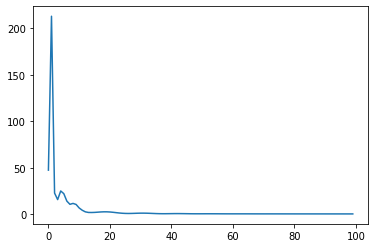

In [79]:
%%time
import math
torch.manual_seed(0)
np.random.seed(0)

num_epochs = 100
batch_size = 10
opt = torch.optim.Adam(model_g.parameters(), lr=0.001)

losses = []
epoch_pbar = tqdm(range(num_epochs), desc="Epochs")

model_g = model_g.train()
for epoch_idx in epoch_pbar:
    all_batch_indices = get_batch_indices(np.arange(len(audiossds_test)), batch_size)
    batch_pbar = tqdm(all_batch_indices, desc=f"Epoch {epoch_idx} Batches")
    for batch_idxs in batch_pbar:
        X_batch, Y_batch = audiossds_train[batch_idxs]
        X_batch, Y_batch = audionnio.audio_to_nn_input(X_batch), audionnio.audio_to_nn_output(Y_batch)
        X_batch, X_batch_phase = X_batch
        X_batch, Y_batch = X_batch.to(device, dtype), Y_batch.to(device, dtype)

        opt.zero_grad()
        Y_batch_pred = model_g(X_batch)
        loss = generator_loss_function_base(Y_batch_pred, Y_batch, X_batch)
        loss.backward()
        opt.step()

        loss = loss.item()
        losses.append(loss)
        batch_pbar.set_postfix({"Loss":loss})
model_g = model_g.eval()

plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, losses

In [82]:
clear_mem(True)

In [83]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print("Test Loss: ", generator_loss_function_base(Y_test_pred, Y_test, X_test).item())

2.9967379570007324+277.2215270996094+0.0=280.21826171875
Test Loss:  280.21826171875


Showing example:  0
Input:


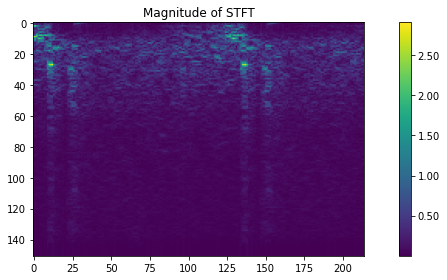

Target:


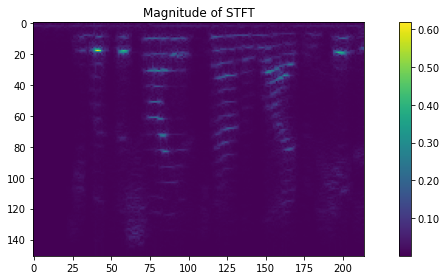

Output:


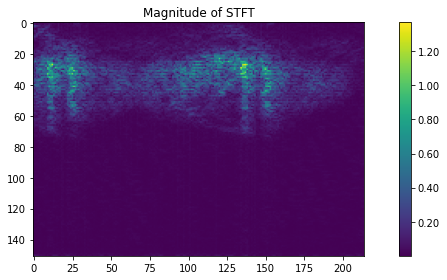

In [84]:
test_example_idx = 0
print("Showing example: ", test_example_idx)
print("Input:")
audionnio.show_play_nn_input(X_test, X_test_phase, ts=["mag", "audio"], sample_idx=test_example_idx)
print("Target:")
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=["mag", "audio"], sample_idx=test_example_idx)
print("Output:")
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=["mag", "audio"], sample_idx=test_example_idx)

In [87]:
torch.save(model_g, f"model_g{100}.pth")